In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.feature_selection import RFE
#!pip install -U joblib
#!pip install --upgrade pip
#!pip install xgboost
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
#!pip install shap
#!pip install --upgrade shap



# 1. Data Split

In [ ]:

data = pd.read_csv('data_to_fit_v3.csv')

# define the target variable
X = data.drop(columns=['Type', 'Market', 'ESG_Rating','Country Name'], errors='ignore')
y = data['ESG_Rating']

# label encoding for the target variable
X_encoded = pd.get_dummies(X, drop_first=True)

# clean column names
X_encoded.columns = X_encoded.columns.str.replace(r"[^a-zA-Z0-9_]", "", regex=True)

# get the feature names
feature_names = X_encoded.columns

# label encoding for the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# convert the numpy array back to a pandas DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=feature_names)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

In [7]:
print("Unique classes in y_train:", np.unique(y_train))
print("Unique classes in y_test:", np.unique(y_test))

Unique classes in y_train: [0 1 2 3]
Unique classes in y_test: [0 1 2 3]


In [8]:
print("Unique classes in original y:", data['ESG_Rating'].unique())


Unique classes in original y: ['A' 'C' 'B' 'D']


# 5. XGboost

In [ ]:
# initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# use GridSearchCV to find the best hyperparameters
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# print the best parameters and the corresponding score
print("Best parameters:", grid_search_xgb.best_params_)
print("Best weighted F1 score:", grid_search_xgb.best_score_)

# use the best model to make predictions
best_xgb_model = grid_search_xgb.best_estimator_

# train the model
y_train_pred = best_xgb_model.predict(X_train)
y_train_pred_proba = best_xgb_model.predict_proba(X_train)

# calculate the accuracy and weighted F1 score
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
print("\nTrain Results: Accuracy:", train_accuracy, "F1 Score:", train_f1)

# calculate the AUC and prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
train_auc = roc_auc_score(y_train_binarized, y_train_pred_proba, multi_class="ovr")
train_prauc = average_precision_score(y_train_binarized, y_train_pred_proba)

print("Train AUC:", train_auc)
print("Train prAUC:", train_prauc)

# make predictions on the test set
y_test_pred = best_xgb_model.predict(X_test)
y_test_pred_proba = best_xgb_model.predict_proba(X_test)

# calculate the accuracy and weighted F1 score
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print("\nTest Results: Accuracy:", test_accuracy, "F1 Score:", test_f1)

# calculate the AUC and prAUC
test_auc = roc_auc_score(y_test_binarized, y_test_pred_proba, multi_class="ovr")
test_prauc = average_precision_score(y_test_binarized, y_test_pred_proba)

print("Test AUC:", test_auc)
print("Test prAUC:", test_prauc)



Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
Best weighted F1 score: 0.6797345996067075

Train Results: Accuracy: 0.9810699588477366 F1 Score: 0.9810483526627564
Train AUC: 0.9995670640777113
Train prAUC: 0.9992168714704023

Test Results: Accuracy: 0.6813819577735125 F1 Score: 0.6768036973828512
Test AUC: 0.841073113086553
Test prAUC: 0.6323063113015217


## best

In [ ]:

tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=3,               # L1 正则化
    reg_lambda=4,              # L2 正则化
    gamma=1,                   # 添加 gamma 限制分裂
    max_depth=10,               # 降低树的深度
    n_estimators=2500,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.8,             # 样本采样率
    colsample_bytree=0.88,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
    min_child_weight=4
)



# train the model
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# binarize the target variable
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# define a function to evaluate the model
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# evaluate the model on the training and testing sets
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# print the results
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Train Results: Accuracy: 0.8436213991769548 F1 Score: 0.8403428191641222 AUC: 0.9665067964876333 prAUC: 0.8899291311057496
Test Results: Accuracy: 0.6986564299424184 F1 Score: 0.6932632838169078 AUC: 0.8487178613634112 prAUC: 0.658326961529811


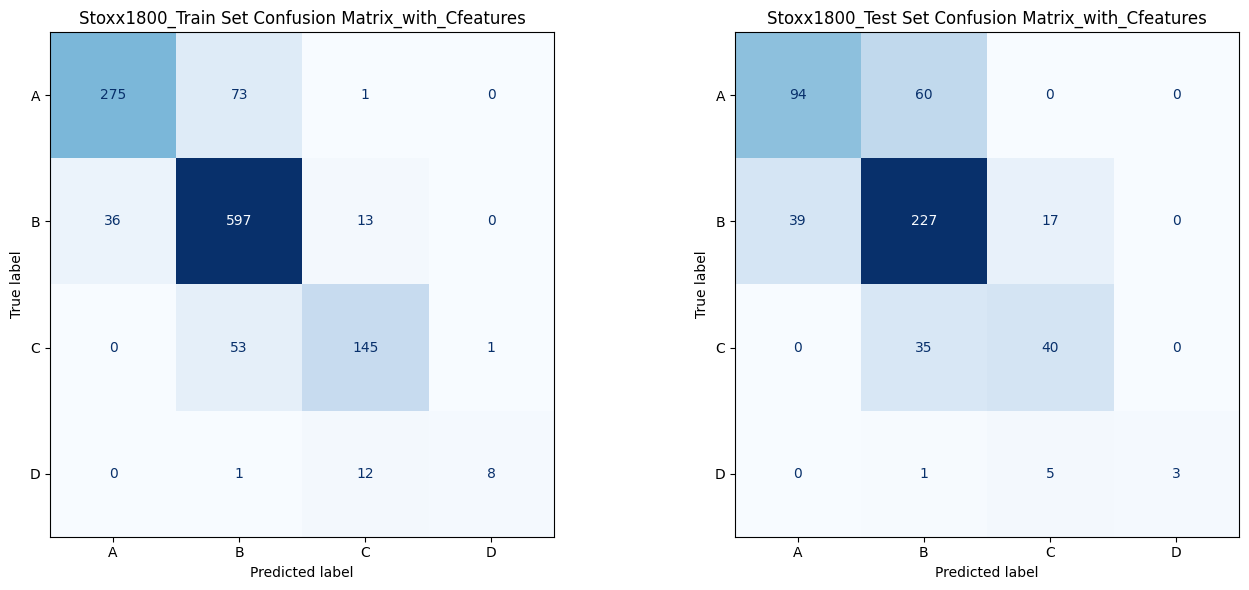

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# make predictions on the training and testing sets
y_train_pred = tuned_xgb_model.predict(X_train)
y_test_pred = tuned_xgb_model.predict(X_test)

# plot the confusion matrix
def plot_combined_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # confusion matrix for the training set
    cm_train = confusion_matrix(y_train, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=label_encoder.classes_)
    disp_train.plot(ax=axes[0], cmap=plt.cm.Blues, colorbar=False)
    axes[0].set_title('Stoxx1800_Train Set Confusion Matrix_with_Cfeatures')

    # confusion matrix for the testing set
    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_encoder.classes_)
    disp_test.plot(ax=axes[1], cmap=plt.cm.Blues, colorbar=False)
    axes[1].set_title('Stoxx1800_Test Set Confusion Matrix_with_Cfeatures')

    plt.tight_layout()
    plt.show()

# plot the confusion matrices
plot_combined_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred)


In [ ]:
# initialize the SHAP explainer
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# print the SHAP values
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values shape (for each class):", [sv.shape for sv in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)


SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (1215, 92, 4)


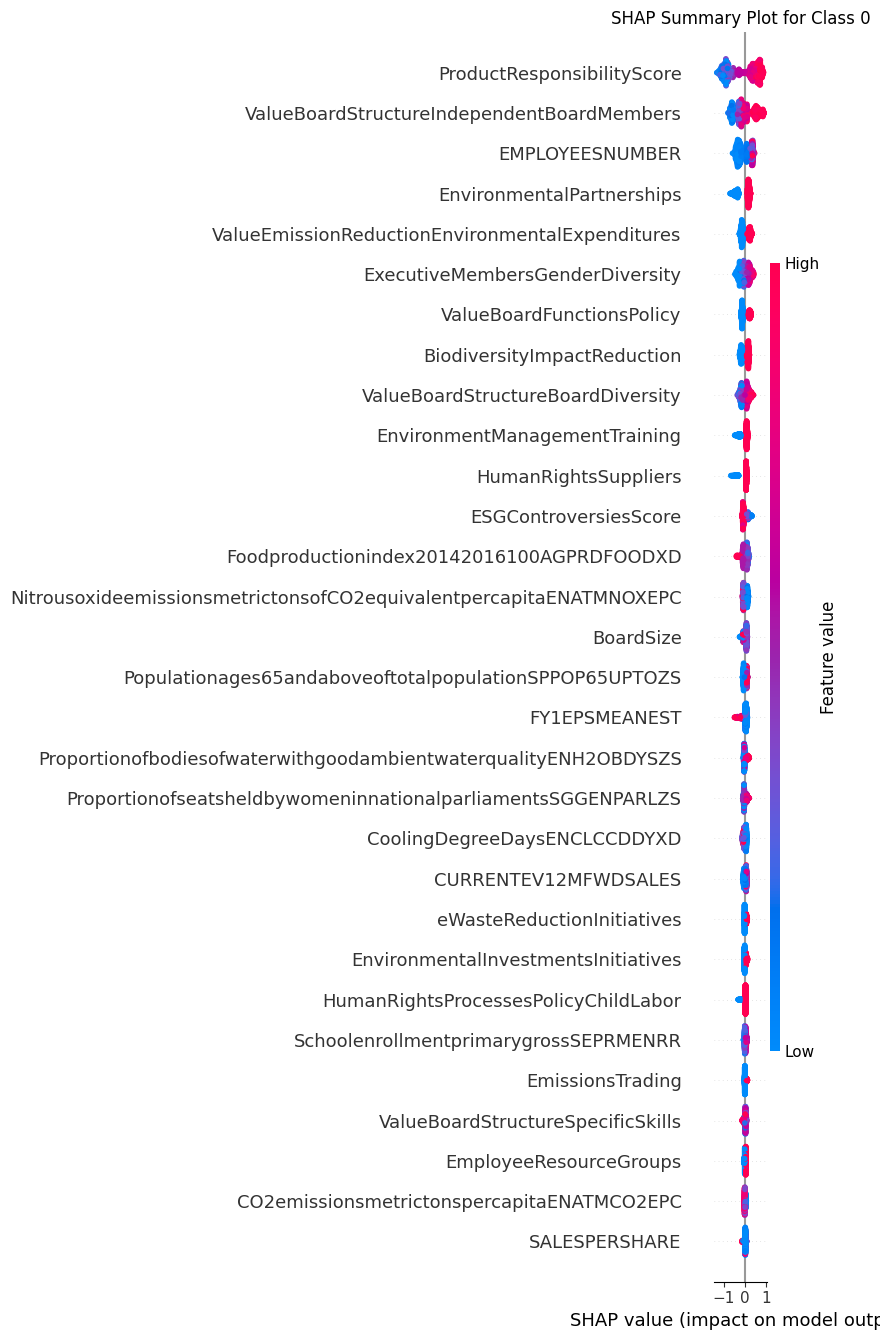

<Figure size 640x480 with 0 Axes>

/Applications/hello/.venv/lib/python3.11/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


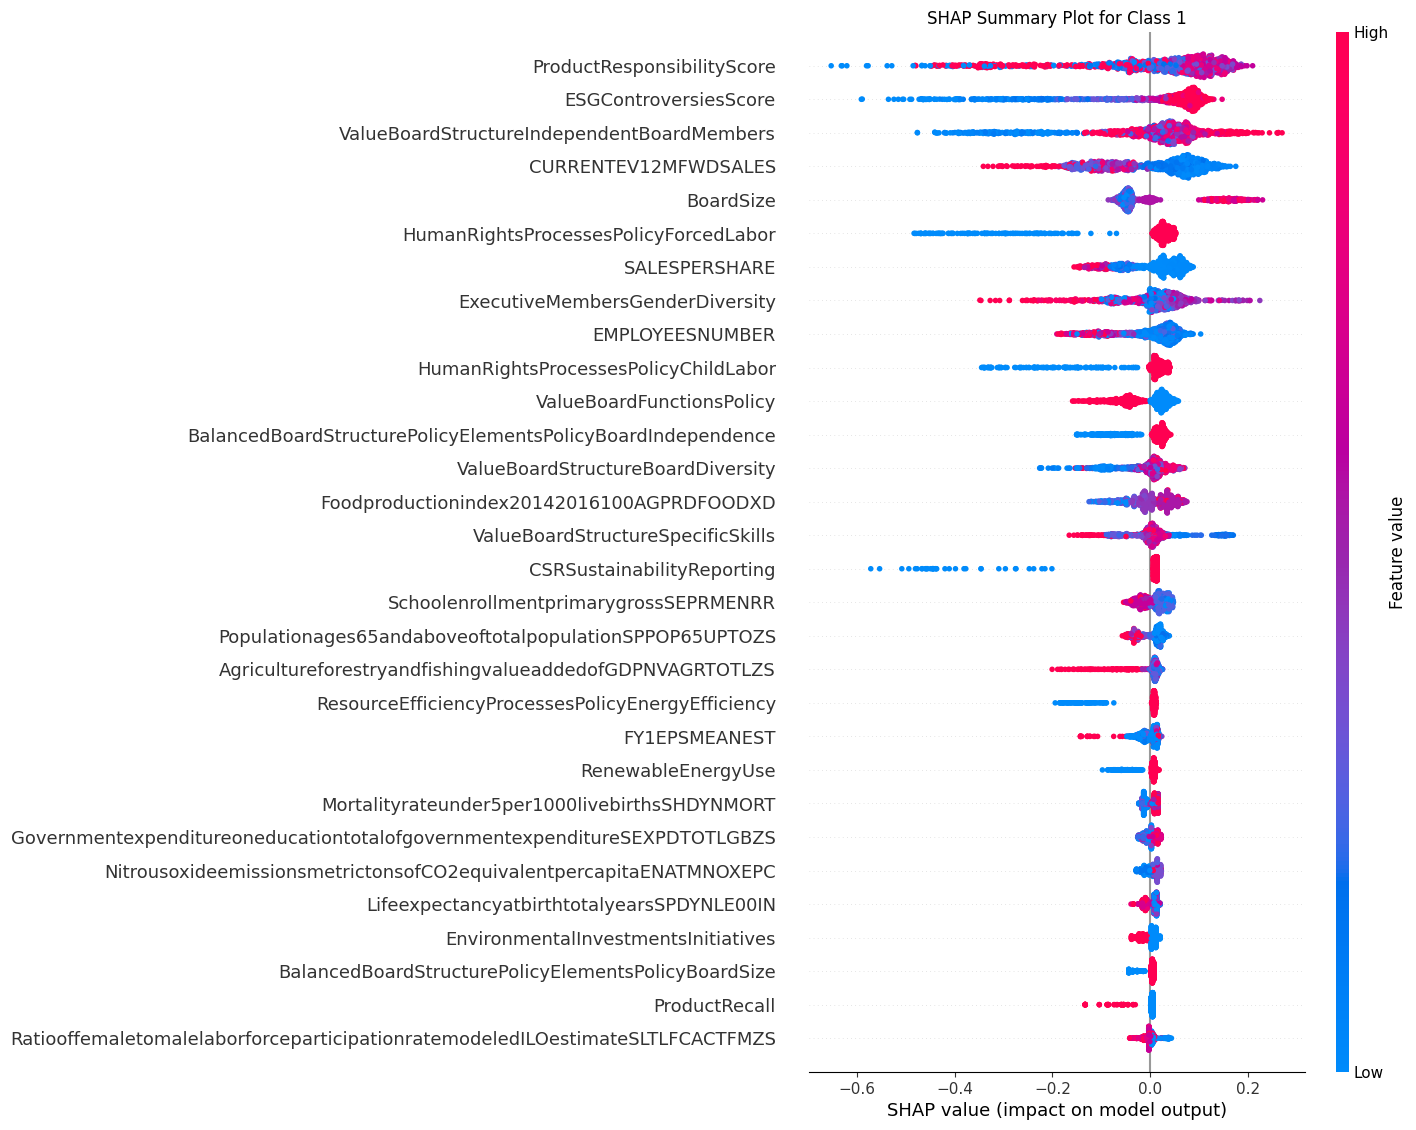

<Figure size 640x480 with 0 Axes>

/Applications/hello/.venv/lib/python3.11/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


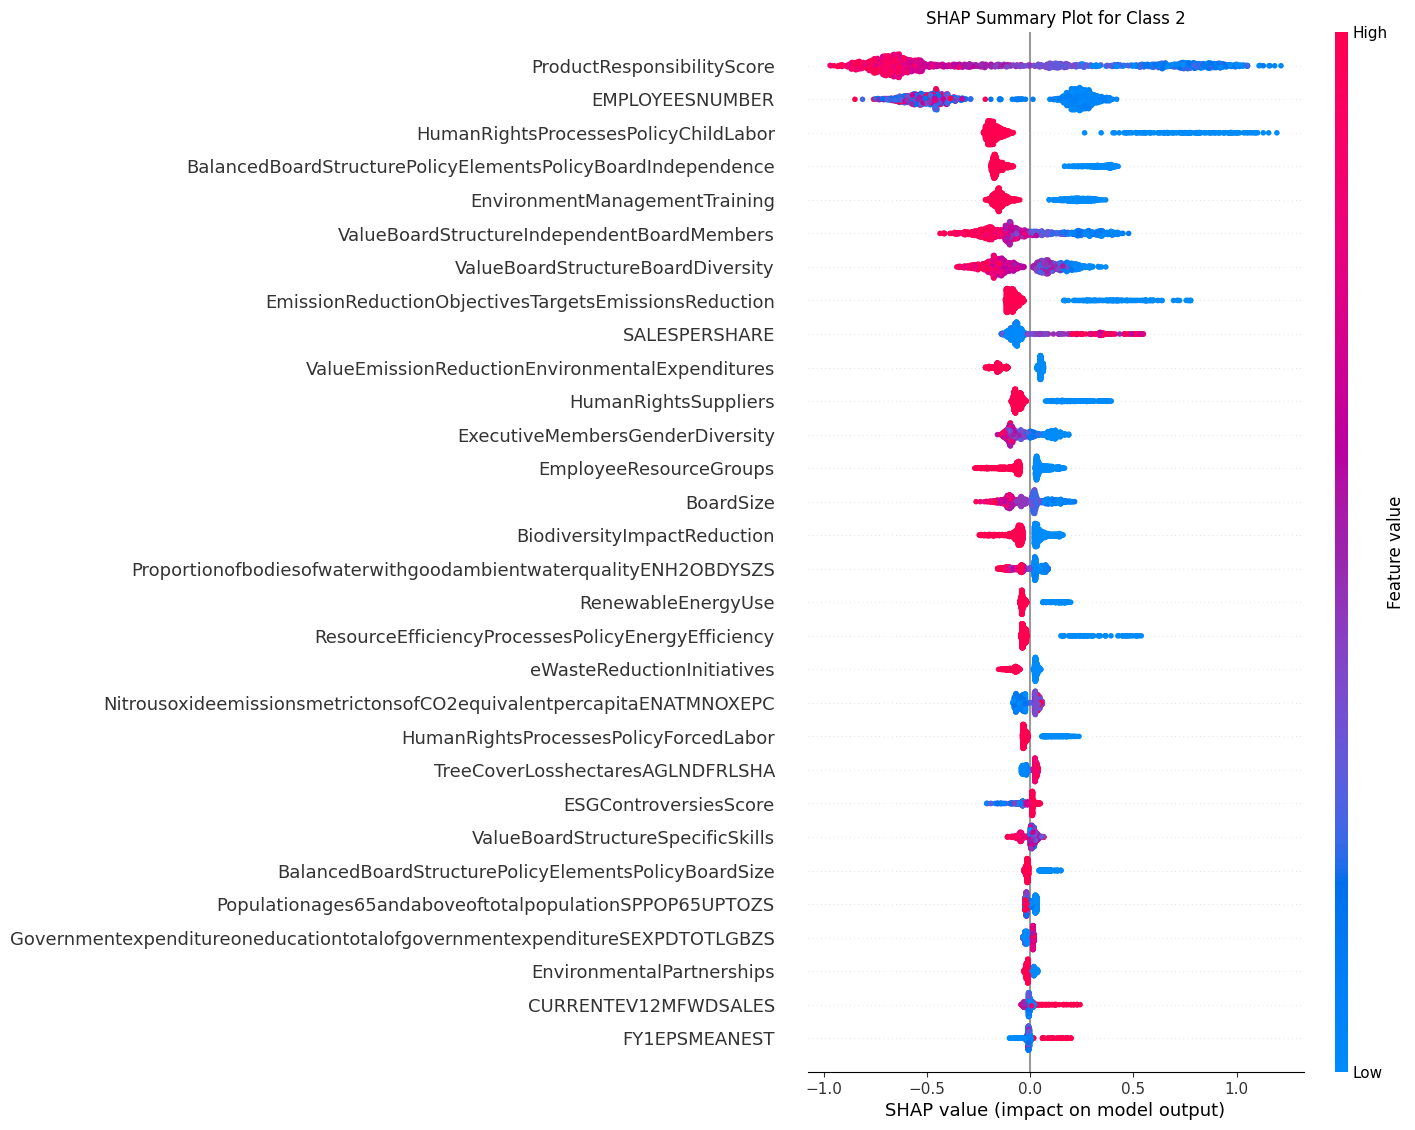

<Figure size 640x480 with 0 Axes>

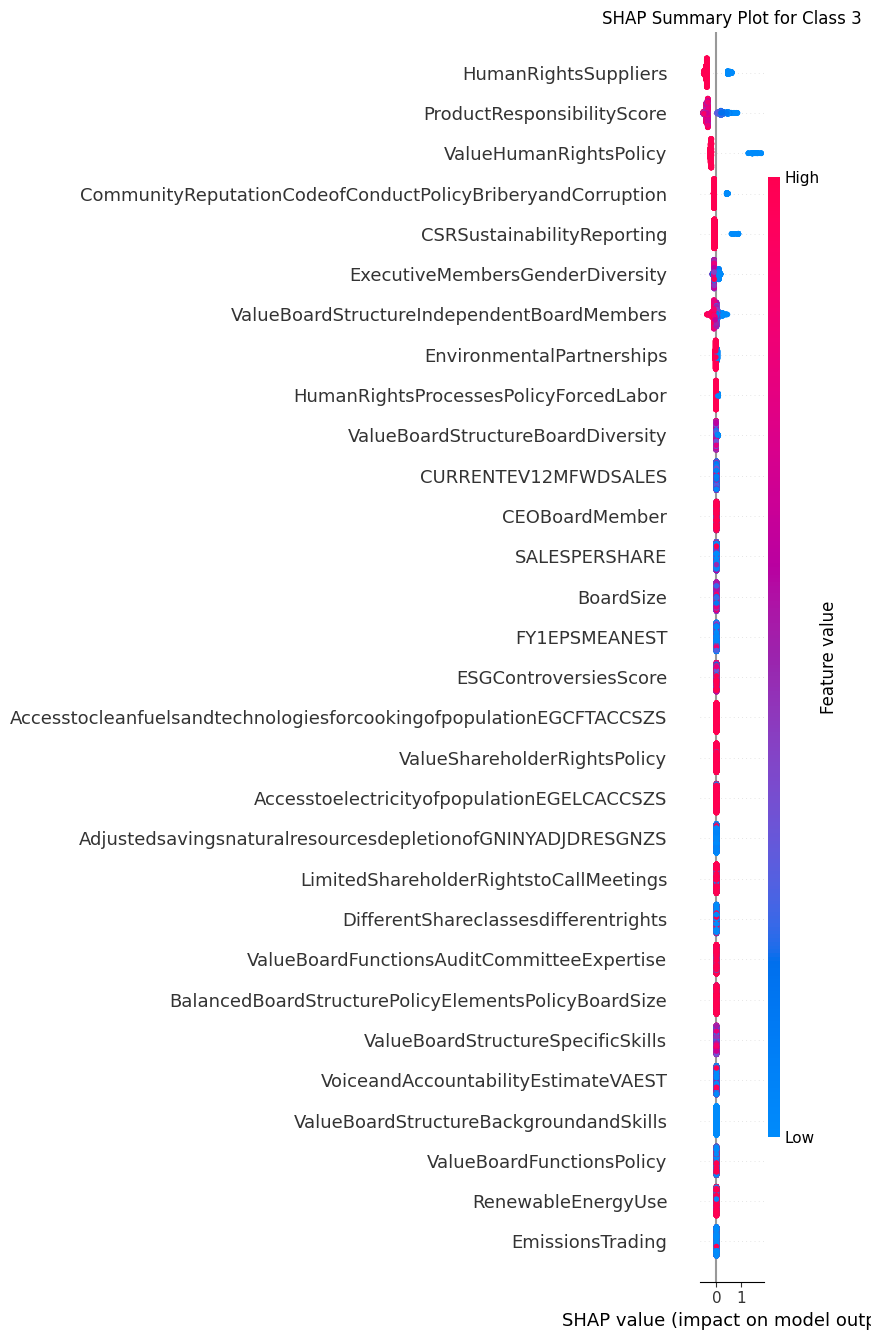

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap
import matplotlib.pyplot as plt

# use the TreeExplainer to get SHAP values
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)


# plot the SHAP summary plot
for i in range(shap_values.shape[2]):  # i 为类别索引
    plt.figure(figsize=(12,6))
    plt.title(f"SHAP Summary Plot for Class {i}")
    shap.summary_plot(shap_values[:, :, i], X_train, feature_names=feature_names, max_display=30)
    plt.tight_layout()  # 自动调整布局
    plt.show()  # 显示图形


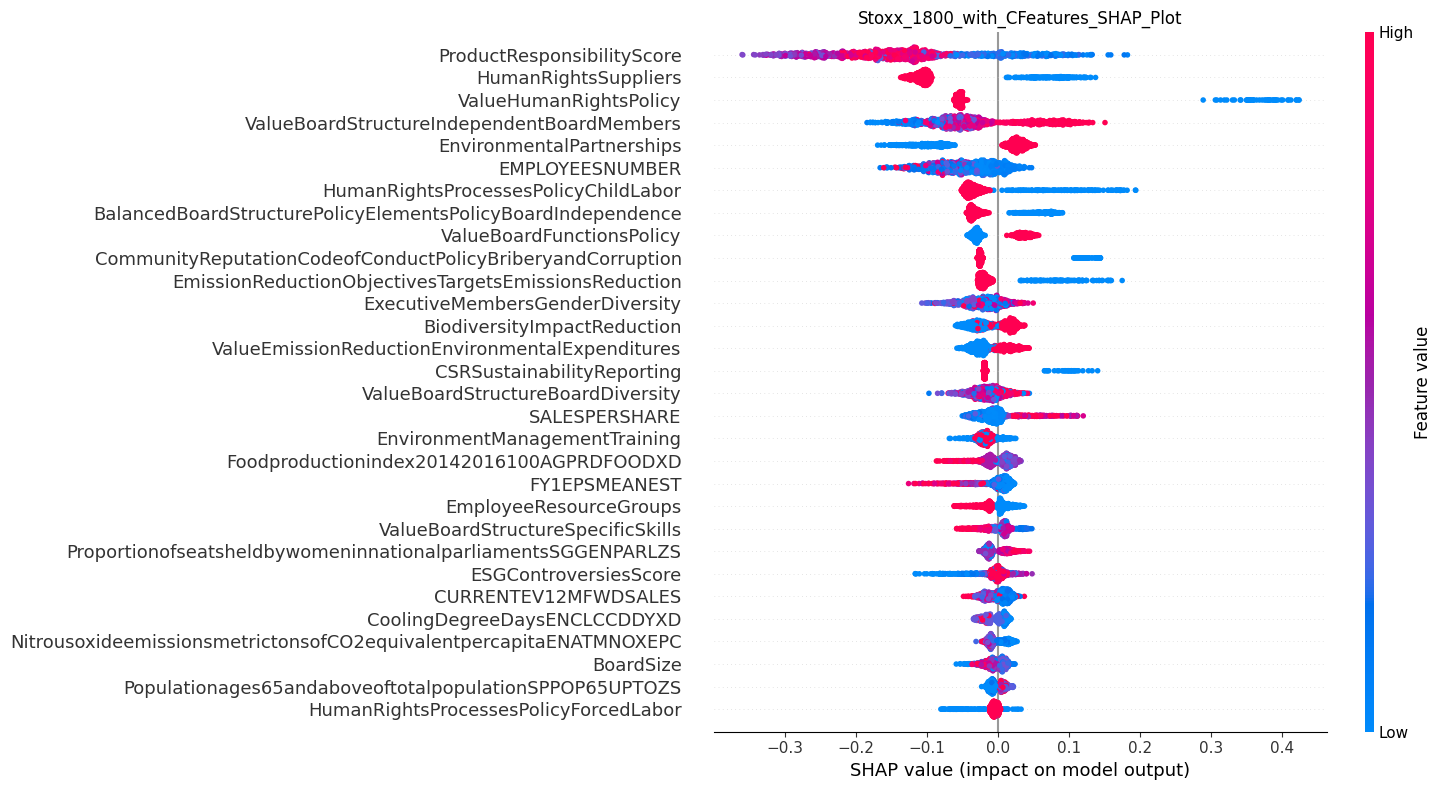

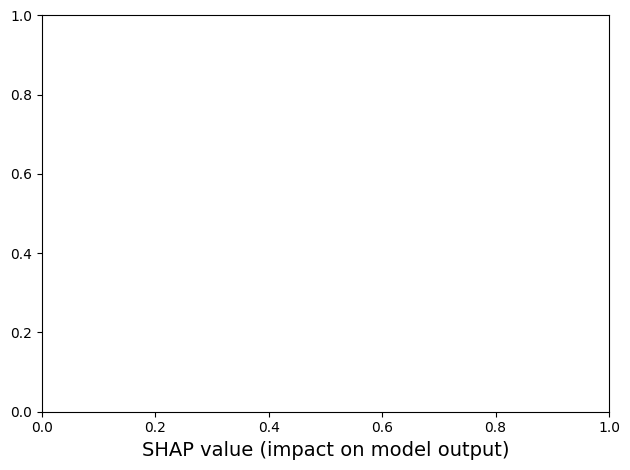

In [ ]:
import shap
import matplotlib.pyplot as plt


explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)


shap_values_mean = shap_values.mean(axis=2)  

# plot the SHAP summary plot
plt.figure(figsize=(15, 8))
plt.title("Stoxx_1800_with_CFeatures_SHAP_Plot")
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30, plot_size=(15, 8))
plt.xlabel("SHAP value (impact on model output)", fontsize=14)  # 增大x轴标签字体
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形
